# analysis of saved npy arrays #

## Setup ##

In [1]:
# Import libraries
import numpy as np
import json as json
import pandas as pd
import math
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
import pylab as pl 
from zoneinfo import ZoneInfo
#import importlib.util
import imp
import sys
import copy
from scipy.ndimage import gaussian_filter1d
from scipy import signal as sg
from scipy.signal import detrend

In [2]:
# Set options
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
#this seems to fix the odd scrolling behavior when charts are present
%matplotlib inline 
pl.rcParams["figure.figsize"] = (15, 6)

In [3]:
# Use dark Background
pl.style.use('dark_background')

### Functions ###

In [4]:
#def load_source(name, path):
#    """Replacement for deprecated imp.load_source."""
#    spec = importlib.util.spec_from_file_location(name, path)
#    if spec is None or spec.loader is None:
#        raise ImportError(f"Can't find spec for {name} at {path}")
#    module = importlib.util.module_from_spec(spec)
#    module.__spec__ = spec           # explicitly set
#    module.__loader__ = spec.loader  # explicitly set
#    sys.modules[name] = module
#    spec.loader.exec_module(module)
#    return module

In [5]:
Lib_name = 'libs'
Lib_path = "/home/mauro/sqrpi/lib/libs.py"

In [6]:
#lb = load_source(Lib_name, Lib_path)

In [7]:
lb = imp.load_source(Lib_name, Lib_path)
print(lb.test_func())

pluto


In [8]:
def plot_array(x_axis, y_axis, title="", xlabel="", ylabel="", grid=True):
    pl.title(title)
    pl.xlabel(xlabel)
    pl.ylabel(ylabel)
    pl.plot(x_axis, y_axis)
    #pl.semilogy(x_axis, y_axis)
    pl.grid(True)
    pl.show()

### Load Settings ###

In [9]:
config=json.loads(open('settings.json','r').read())

In [10]:
config

{'window': 180,
 'sample_rate': 4,
 'offset_x': -0.0154,
 'offset_y': 0.0117,
 'offset_z': -0.0087,
 'offset_pitch_d': 0.57,
 'offset_roll_d': 0.48,
 'fwd_nmea': False,
 'ipmux_addr': 'localhost',
 'ipmux_port': 10110,
 'orientation': 0,
 'vessel_lw': 10}

In [11]:
window = config['window'] # length of observation frame (in secs)
sample_rate = config['sample_rate'] # Hz
offset_x = config['offset_x']
offset_y = config['offset_y']
offset_z = config['offset_z'] # run calibrate.py to update this value, with sensor board resting as horizontal as possible
ipmux_addr = config['ipmux_addr']  # destination of NMEA UDP messages 
ipmux_port = config['ipmux_port'] 
pitch_on_y_axis = config['orientation'] # Rpi oriented with longest side parallel to fore-aft line of vessel (0) or perpendicular (1)

sample_period = 1.0/sample_rate
n = int(window*sample_rate) 
df = float(sample_rate)/float(n)

## Load NPY arrays ##

Read the arrays from saved files

In [12]:
npydir = 'npyfiles/fieldtests/'
run = '2025_09_27_13_02' 

In [61]:
freqs    = np.load(f'{npydir}freqs_{run}.npy')
signal   = np.load(f'{npydir}signal_{run}.npy')
acc_spectrum = np.load(f'{npydir}acc_spectrum_{run}.npy')
heave_spectrum   = np.load(f'{npydir}heave_spectrum_{run}.npy')
print('signal: ', len(signal), 'acc_spectrum: ', len(acc_spectrum))

signal:  720 acc_spectrum:  37


In [14]:
#signal = np.load(f'{npydir}signal_corr.npy')

## Signal analysis ##

In [15]:
w=40
mavg_signal = lb.moving_average(signal,w)
ls =  len(signal)
print(len(signal),len(mavg_signal))

720 681


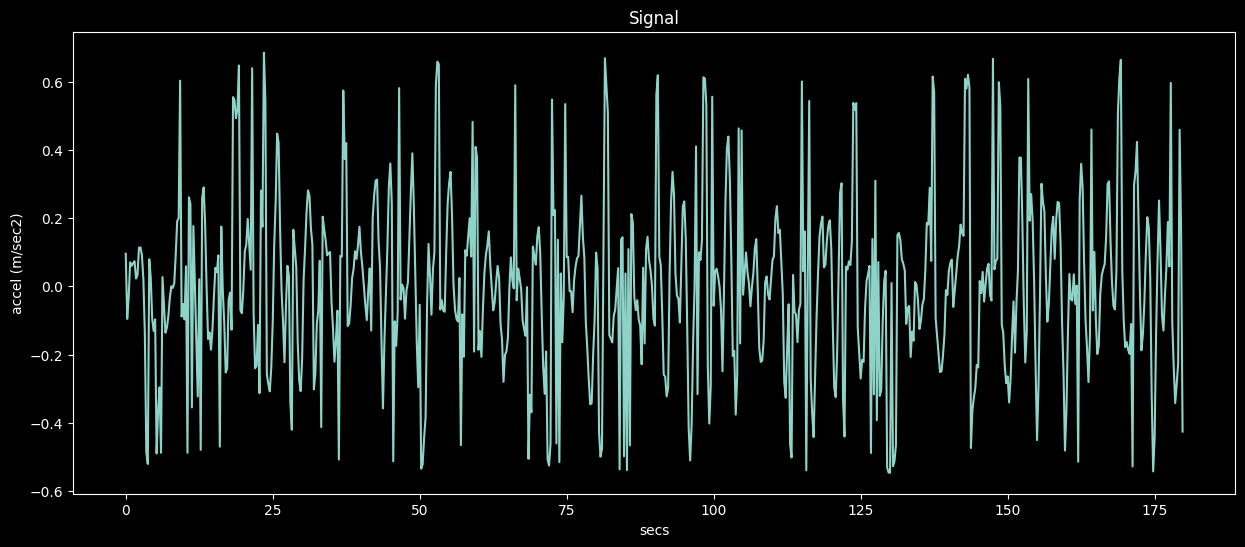

In [16]:
fr=100
fr = 0
to=140
to = ls
pl.title('Signal')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
# moving average
#pl.plot([float(i)/float(sample_rate) for i in range(int(w/2)-1, ls-int(w/2) )],mavg_signal)
# raw signal
pl.plot([float(i)/float(sample_rate) for i in range(fr,to)],signal[fr:to] )
pl.show( )

Filter using gaussian

In [17]:
#signal_corr = gaussian_filter1d(signal, sigma=6)

Filter using butter

In [18]:
freq_low = 0.05 # Hz. Sets high-pass filter. Set to 0 for low_pass only
freq_high = 0.4 # Hz. Sets low-pass filter. 

nyq_freq = sample_rate/2

# low pass filter
b, a = sg.butter(4, freq_high/nyq_freq, btype='low', analog=False)
signal_corr = sg.filtfilt(b, a, signal)

if freq_low > 0:
    # high pass filter
    d, c = sg.butter(4, freq_low/nyq_freq, btype='high', analog=False)
    print("freq >: ", round(freq_low,2), 'Hz (', round(1/(freq_low),2),'s)')
    signal_corr = sg.filtfilt(d, c, signal_corr)

print('freq <: ' , freq_high, 'Hz (',1/freq_high, 's)')    

freq >:  0.05 Hz ( 20.0 s)
freq <:  0.4 Hz ( 2.5 s)


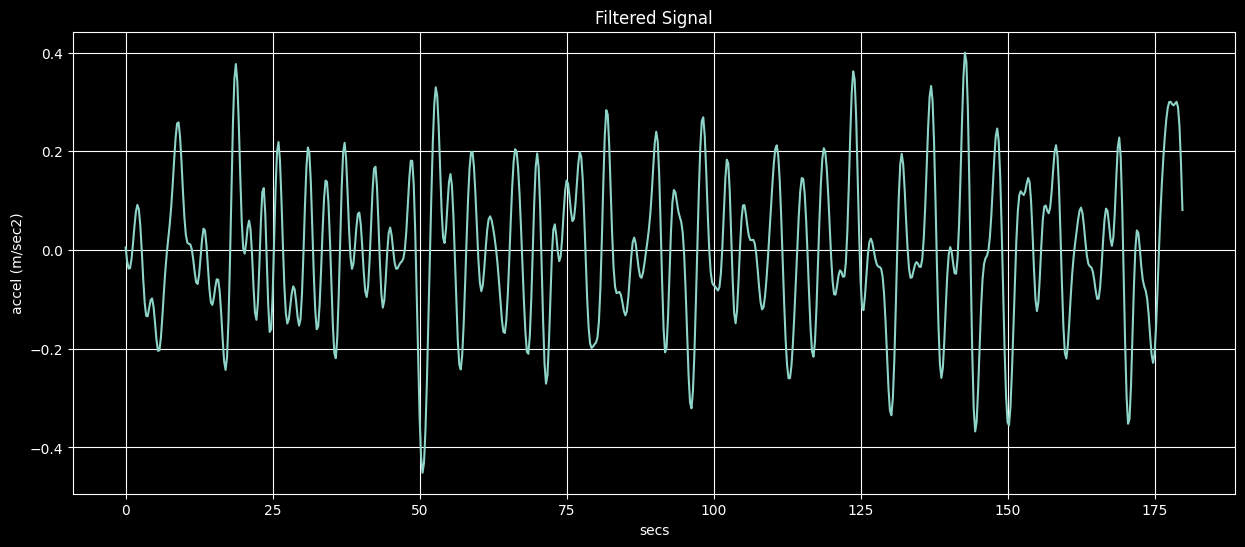

In [19]:
pl.title('Filtered Signal')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
pl.plot([float(i)/float(sample_rate) for i in range(0,ls)], signal_corr[0:ls])
pl.grid(True)
pl.show()

In [20]:
# subtract moving average
signal_corr = np.concatenate([signal[:w-1], signal[w-1:]-mavg_signal] )

In [21]:
np.save(f'{npydir}signal_corr', signal_corr)

## Spectral analysis ##

### Acceleration -> Modal Wave Period ###

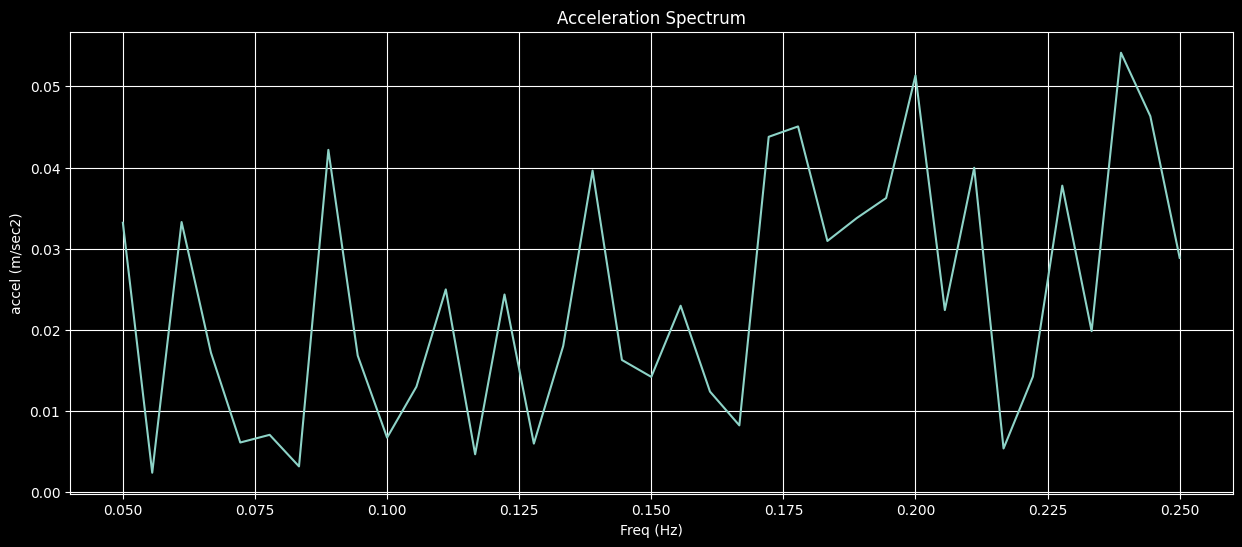

In [22]:
plot_array(freqs, acc_spectrum, 'Acceleration Spectrum', 'Freq (Hz)', 'accel (m/sec2)') 

Gaussian filtering

In [23]:
gauss = gaussian_filter1d(acc_spectrum, sigma=2)
max_index = np.argmax(gauss)

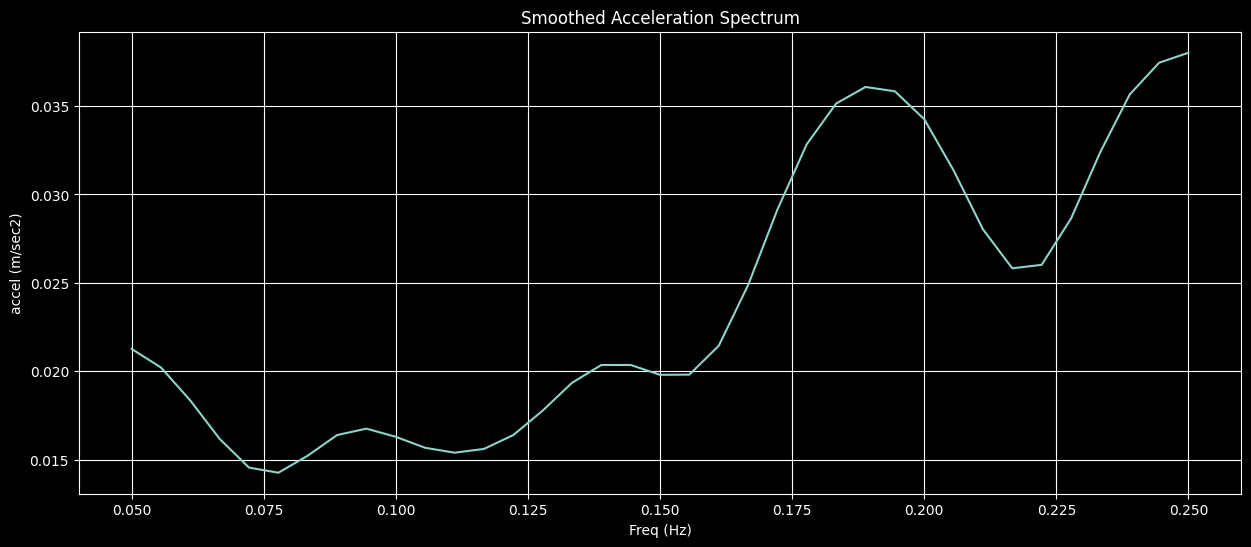

In [24]:
plot_array(freqs, gauss, 'Smoothed Acceleration Spectrum', 'Freq (Hz)', 'accel (m/sec2)')
#plot_array(freqs, gauss)

Modal period

In [25]:
modal_freq = freqs[max_index]
modal_per = 1/modal_freq
print('Modal period', round(modal_per,3))

Modal period 4.0


### Heave ###

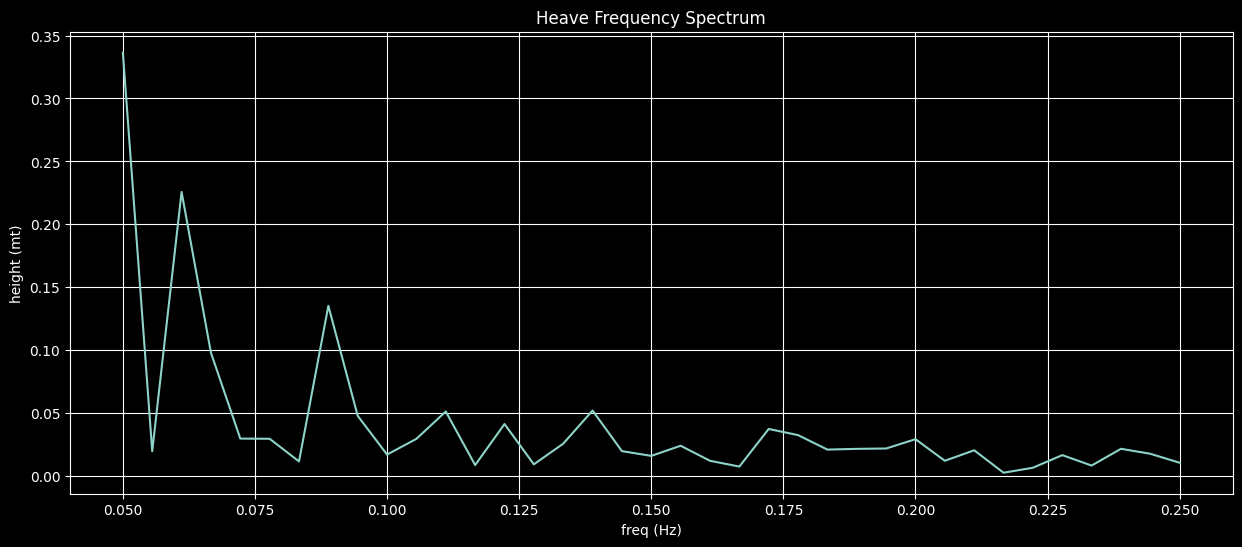

In [26]:
plot_array(freqs, heave_spectrum, 'Heave Frequency Spectrum', 'freq (Hz)', 'height (mt)')

In [27]:
freqs.shape

(37,)

### Power Spectral Density -> Dominant Wave Period ###

In [28]:
low_cutoff = 0
freqs_c = freqs[low_cutoff:]

In [29]:
freqs_c.shape

(37,)

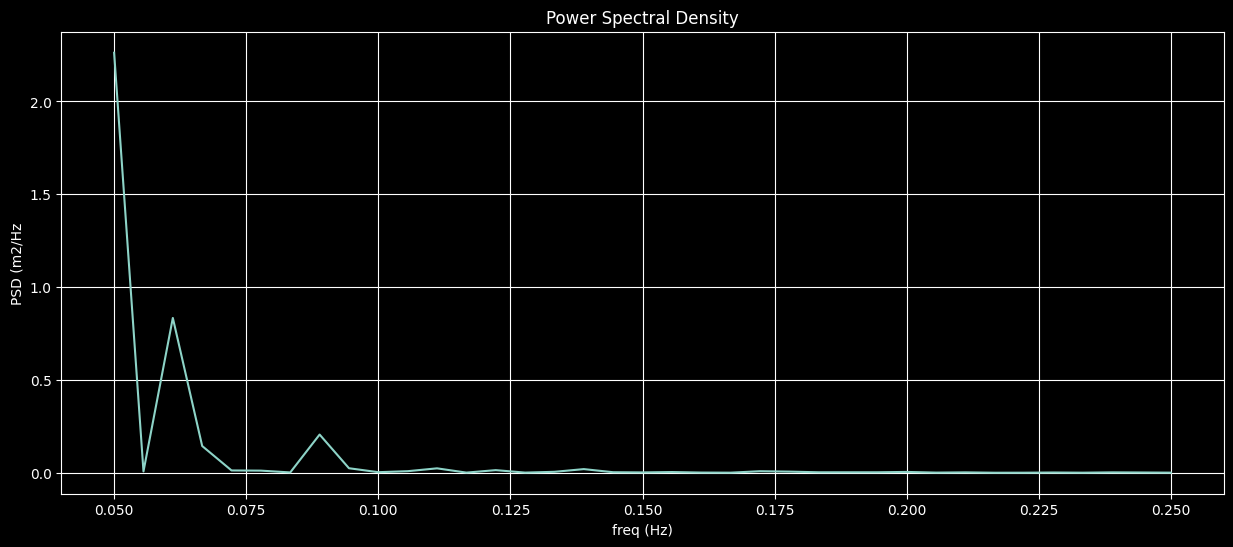

In [30]:
psd = (heave_spectrum[low_cutoff:]**2)/freqs_c
plot_array(freqs, psd, 'Power Spectral Density', 'freq (Hz)', 'PSD (m2/Hz')

Dominant Period using PSD

In [31]:
max_index = np.argmax(psd)
print('max_index', max_index, "Dominant period", 1/freqs[low_cutoff:][max_index])

max_index 0 Dominant period 20.0


### PSD -> Significant Wave Height ###

In [32]:
m0  = sum(psd*df)
sig_wave_height = 4 * math.sqrt(m0) 
print("significant wave height", sig_wave_height)

significant wave height 0.5672527153734591


### PSD -> Average wave period ###

In [33]:
f2=freqs_c**2
m2=sum(np.multiply(psd,f2)*df)
print('Average Wave Period: ', math.sqrt(m0/m2))

Average Wave Period:  16.06613309154301


## Spectral analysis from signal ##

Recalculate all spectra starting from raw signal using the functions in libs

In [34]:
lb = imp.load_source(Lib_name, Lib_path)

In [35]:
signal = detrend(signal, type='linear')

In [36]:
freqs, acc_spectrum = lb.transform(signal, sample_rate, min_period=2, max_period=20)

In [37]:
heave_spectrum = lb.heave(freqs, acc_spectrum)
avg_pitch = 5.5
avg_roll = 15
heave_spectrum = lb.inv_rao(heave_spectrum, freqs, 10, avg_pitch, avg_roll)

In [38]:
sig_wave_height, dom_period, modal_period, avg_period =  lb.calc_swh(freqs, df, acc_spectrum, heave_spectrum)
print("Significant Wave Height: ", sig_wave_height)

Significant Wave Height:  0.5675295453543143


Using welch

This approach is invalid as it caclulates the power spectrum of the acceleration, not heave. See dimensional check 

In [39]:
from scipy.signal import welch
Fs=4.0

In [40]:
fx, psx = welch(signal, fs=Fs, window='hann', nperseg=60, noverlap=30)

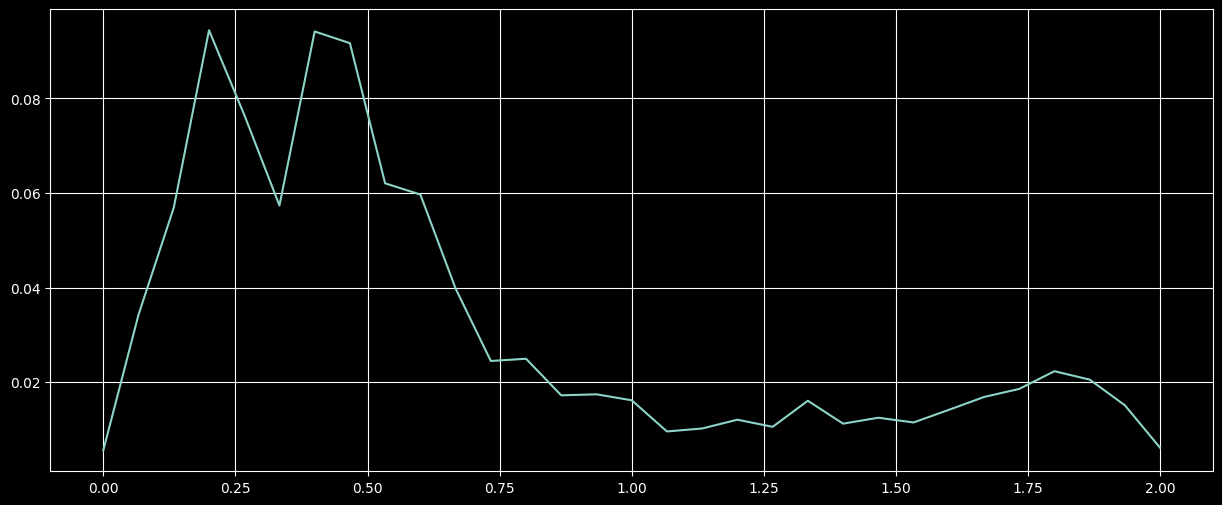

In [41]:
plot_array(fx, psx)

In [42]:
fx.shape

(31,)

In [43]:
dx=2/fx.shape[0]

In [44]:
m0  = sum(psx*dx)
sig_wave_height = 4 * math.sqrt(m0) 
print("significant wave height", sig_wave_height)

significant wave height 1.0059529358139976


In [45]:
max_index = np.argmax(psx)
print('max_index', max_index, "Dominant period", 1/freqs[low_cutoff:][max_index])

max_index 3 Dominant period 15.0


In [46]:
f2=fx**2
m2=sum(np.multiply(psx,f2)*dx)
print('Average Wave Period: ', math.sqrt(m0/m2))

Average Wave Period:  1.1761058567205809


Direct double integration of signal

In [72]:
sample_period = 1/sample_rate

In [70]:
signal_clean = detrend(signal, type='linear')

In [110]:
t = np.arange(n) / sample_rate
signal_clean = 1*np.sin(2*pi*0.05*t) #+ a2*np.cos(2*pi*0.13*t)

In [138]:
vel = np.cumsum(signal_clean*sample_period)

In [125]:
(vel[1]-vel[0])/sample_period

0.07845909572784494

In [127]:
heave = np.cumsum(vel*sample_period)-pi

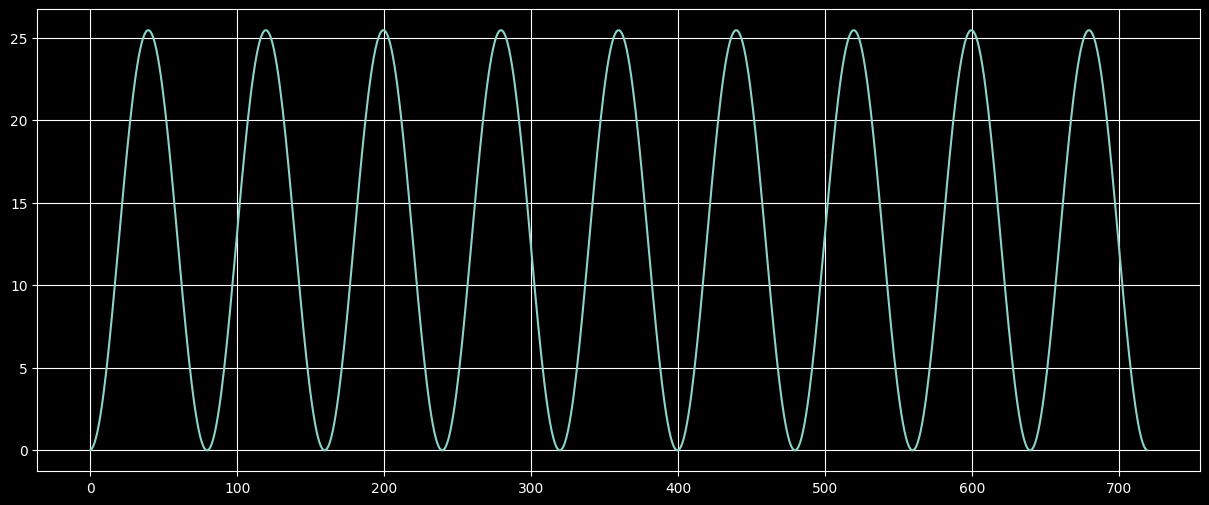

In [137]:
pl.grid(True)
pl.plot(vel)

## Misc dev ##

### Amplitude Spectral Density ###

In [49]:
asd = np.sqrt(psd)

In [50]:
m0  = sum(asd*df)
sig_wave_height = 4 * math.sqrt(m0) 
sig_wave_height

0.6832399536631212

#### calculate SWH from time series ####

this makes no sense as it is calculated on acceleration, not displacement

In [51]:
m0 = np.var(signal)

In [52]:
sig_wave_height = 4 * math.sqrt(m0) 
sig_wave_height

1.0252738255809064

### MATH ###

In [53]:
pi = np.pi

In [54]:

#signal = 2.0*np.sin(2*np.pi*0.05*tm) + 1*np.sin(2*np.pi*0.2*tm) + 0.05*np.random.randn(n)
f = 0.01 # this must be the same for all signals in order for the result to be a sine function, and for amp and ph below to be valid
a1 = 2
a2 = 1

ph1 = 0
ph2 = pi/2
real = a1 * np.cos(ph1) + a2 * np.cos(ph1)
img =  a1 * np.sin(ph1) + a2 * np.sin(ph2)
amp = math.sqrt(a1**2 + a2**2)
ph  = np.arctan(img/real)
print('ampl: ', round(amp,2) , 'phase: ', round(ph,2))

ampl:  2.24 phase:  0.32


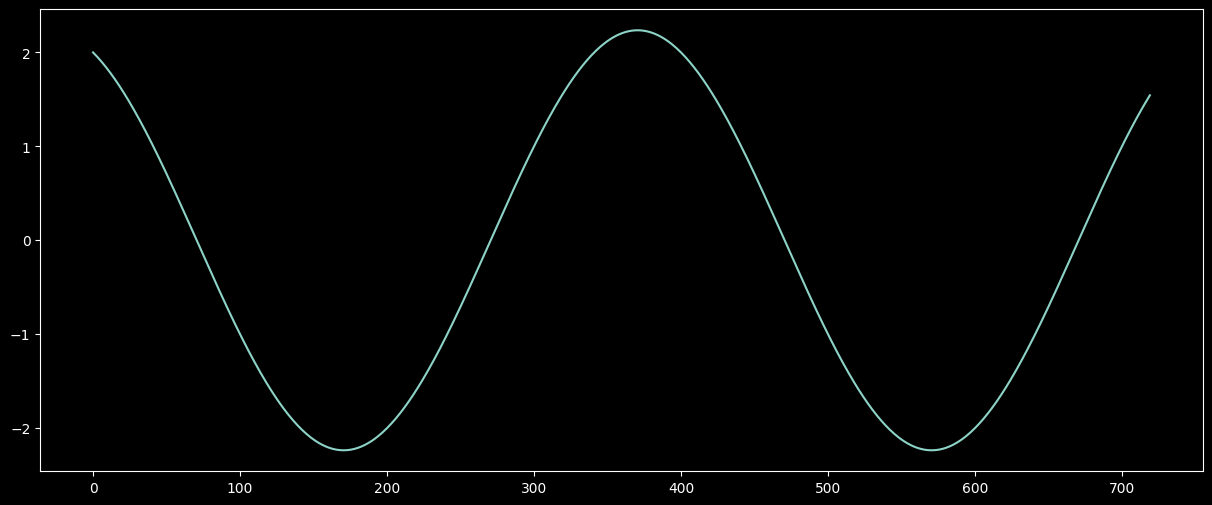

In [55]:
t = np.arange(n) / sample_rate
signal = a1*np.cos(2*pi*f*t + ph1) + a2*np.cos(2*pi*f*t + ph2)
#signal = np.sin(2*np.pi*0.01*tm+np.pi/2)

# espressed as phasor: a1 * e ** j(2*pi*f*t + ph1)
pl.plot(signal)